# Ch 9 - Unsupervised Learning Techniques

This notebook contains the code for Ch 9; see the notes on GitHub for more details.

## K-Means Clustering

To start, we will create some artifical cluster data, and then use the k-means algorithm to attempt to define the clusters.

In [1]:
from sklearn.datasets import make_blobs

In [2]:
import numpy as np
np.random.seed(42)

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [3]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [4]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

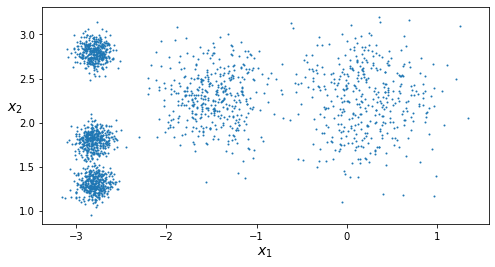

In [5]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

Now that we have our data, let's implement the k-means clustering algorithm!

In [6]:
from sklearn.cluster import KMeans

In [7]:
k = 5
kmeans = KMeans(n_clusters=k)

In [8]:
y_pred = kmeans.fit_predict(X)

By doing this, the k-means algorithm has identified for us five clusters. Each cluster can be identified by its **centroid**:

In [9]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

Since we have specified SKL to look for five clusters, each instance has been assigned to one of these five clusters, which are denoted as 0,1,2,3,4:

In [10]:
y_pred[:10]

array([0, 4, 1, 4, 4, 0, 4, 4, 3, 4])

This means the first instance was assigned to belong in the first cluster (the one with centroid $(-2.80, 1.30)$), the second instance was assigned to the fourth cluster (the one with centroid $(-2.80, 1.80)$), and so on.

In [11]:
kmeans.labels_

array([0, 4, 1, ..., 2, 1, 4])

We note that these assignments are called **labels**, but not in the sense of having a labelled data set!

Finally, we can now use our k-means ML model on new inputs too. A new input is assigned to that cluster to which its centroid is closest to the input.

In [12]:
X_new = np.array([ [0,2], [3,2], [-3,3], [-3, 2.5] ])

In [13]:
kmeans.predict(X_new)

array([1, 1, 2, 2])

These assignments of the four new data points to the clusters make perfect sense when we look at the model's decision boundaries. The decision boundaries form what is called a **Voronoi diagram** (aka: *Voronoi tessellation*).

In [14]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

In [15]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

In [16]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

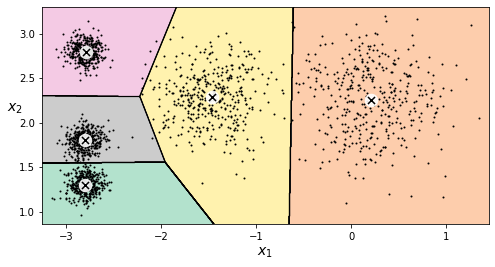

In [17]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

We can compute the distances of any instance to each cluster centroid using the 'transform()' method:

In [18]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

This output means that, for example, for the first instance $[0,2]$ has distances:
* 2.81 from the first cluster
* 0.33 from the second cluster,
* 2.90 from the third cluster

and so on.

**Centroid Initialization Methods**

In [19]:
approximate_centroids = np.array([ [-3,3], [-3,2], [-3,1], [-1,2], [0,2] ])

In [20]:
kmeans = KMeans(n_clusters=5, init = approximate_centroids, n_init = 1)

In [21]:
kmeans.fit_predict(X)

array([2, 1, 4, ..., 0, 4, 1])

In [22]:
kmeans.inertia_

211.62337889822362

In [23]:
kmeans.score(X)

-211.6233788982236

**Finding the Optimal Number of Clusters**

One way to get an initial understanding of the optimal number of clusters is to use the "elbow method". We will plot the inertia of various k-means models with respect to the number of clusters, and look at the resulting plot for the elbow:

In [24]:
# Initializing and fitting various k-mean class objects, with different k values

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

In [25]:
# Extracting the inertia of each model

inertias = [model.inertia_ for model in kmeans_per_k]

(1.0, 8.5, 0.0, 1300.0)

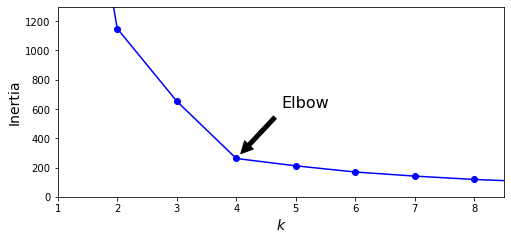

In [26]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

So, we see that the elbow occurs when the number of clusters $k=4$, and this would be a perfectly fine choice for $k$.

We can also plot the various **silhouette scores** for the above k-mean models:

In [27]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [28]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

(1.8, 8.5, 0.55, 0.7)

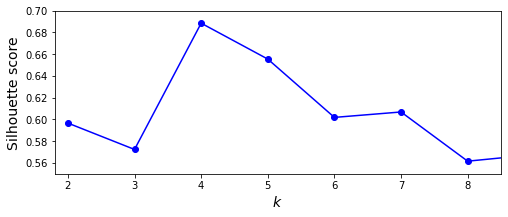

In [29]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

Here, we can see that $k=4$ does indeed yield the highest silhouette score. But even moreso, this plot shows use that $k=5$ is also a decent choice, and this fact is **not present in the previous plot**!!!

Finally, we can also look at the **silhouette diagram** as well:

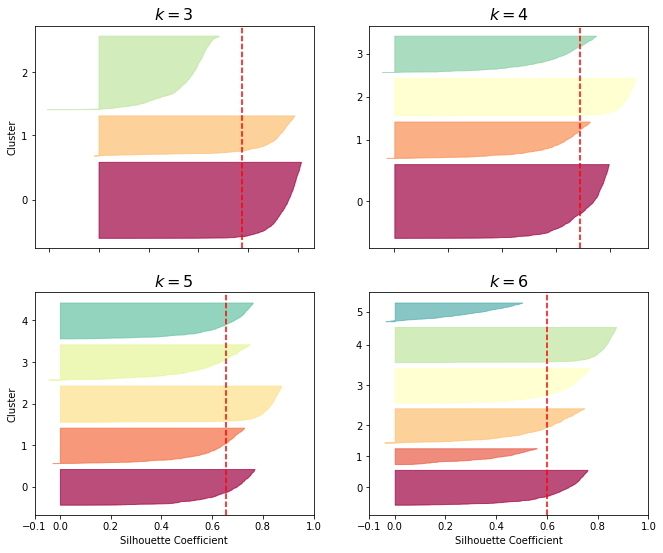

In [30]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

### Using Clustering for Image Segmentation

### Using Clustering for Preprocessing

### Using Clustering for Semi-Supervised Learning

## DBSCAN

We illustrate the use of SKL's 'DBSCAN' class using the 'moons' data set.

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 1000, noise = 0.05)

In [32]:
dbscan = DBSCAN(eps = 0.05, min_samples = 5)

In [33]:
dbscan.fit(X)

DBSCAN(eps=0.05)

We can visualize how our data has been classified under DBSCAN:

In [34]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [35]:
dbscan2 = DBSCAN(eps = 0.2, min_samples = 5)
dbscan2.fit(X)

DBSCAN(eps=0.2)

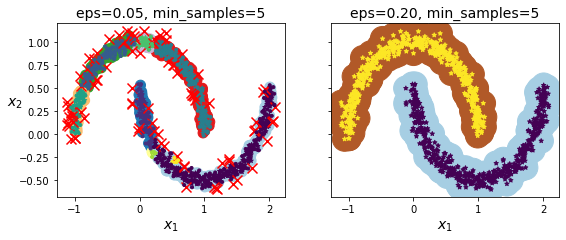

In [36]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

In the left-hand picture, we see that the DBSCAN algorithm (using neighborhoods of radius 0.05) have split the moons data into six different clusters and has also identified many anomalies.

Of course, this is not what we were expecting! We wanted there to only be two clusters, one for the upper curve and one for the lower.

Indeed, if we increase the neighborhood radius to 0.2, we get the image on the right, which IS what we would expect.

We are also able to extract useful information about the clusters. First, we can see what the labels for each input instance is - this is stored in the 'labels_' variable. We notice that some of the labels are -1, which represent the anomalies.

In [37]:
dbscan.labels_

array([ 0,  0,  0,  1,  1,  0,  0,  1,  2,  3, -1,  4,  0,  5, -1,  1,  0,
       -1,  4,  3,  0,  0,  3,  4,  1,  1,  0, -1, -1,  0,  4,  0,  3,  1,
        0,  3,  0, -1,  2,  3, -1,  2,  2,  5,  2,  2,  0,  1,  1,  0,  0,
        2,  3,  0,  0,  2,  0,  3,  3,  3, -1,  4,  3, -1,  0,  0,  4,  3,
        0, -1,  3,  3,  4,  3,  0,  1,  0,  0,  3,  1,  4,  1,  3,  0,  3,
        2,  1,  4,  2,  5,  2,  0,  1,  1,  0,  0,  3, -1,  3,  3,  0,  0,
        3,  0, -1,  2,  1,  0,  0,  2,  0,  2,  0,  0,  0, -1,  0,  0,  2,
        1,  3,  0,  0,  0,  4,  0,  3,  2,  4,  3, -1,  7,  0,  0,  3,  1,
        3,  3, -1,  3,  3,  3,  2,  0,  4,  2,  0,  3, -1,  2,  0,  0,  0,
        1,  0,  0,  0,  0,  4,  3, -1,  4,  1,  4,  2,  0,  1,  1,  2,  2,
        2,  5,  1,  1,  3,  0,  0,  2,  1,  0,  5,  2,  1,  0,  2,  1,  0,
        3,  2,  2,  2,  0,  1, -1, -1,  5,  3,  0,  0,  3,  2, -1,  3,  0,
        2, -1,  0,  0,  3,  0,  1, -1, -1,  3,  2,  0,  4,  0,  0,  1,  0,
        5,  5,  2,  4,  2

We can also see which instances DBSCAN determined to be core instances; this information is stored in the 'core_sample_indices_' variable. We see that DBSCAN determined that 779 instances are core instances:

In [38]:
len(dbscan.core_sample_indices_)

779

In [39]:
dbscan.core_sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  15,  16,
        19,  20,  22,  23,  24,  25,  26,  30,  31,  34,  35,  36,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  51,  52,  53,
        54,  55,  56,  58,  59,  61,  64,  65,  66,  67,  68,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  86,
        87,  88,  89,  91,  93,  94,  95,  96,  98,  99, 100, 102, 103,
       105, 106, 107, 108, 109, 111, 112, 113, 116, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 133, 134, 135, 136, 139,
       140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154,
       155, 156, 159, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171,
       172, 173, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 195, 197, 198, 199, 200, 202, 203,
       206, 207, 208, 209, 210, 213, 215, 216, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 228, 229, 230, 231, 235, 238, 239, 24

Finally, we can also see the actual core instances themselves, this information being stored in the 'components_' variable:

In [40]:
dbscan.components_

array([[ 0.34797786, -0.28071909],
       [ 0.45005145, -0.27308464],
       [ 0.59433068, -0.4107006 ],
       ...,
       [ 0.86829555,  0.49950359],
       [-0.91224491,  0.29106753],
       [-0.43400602,  0.89030869]])

It may come as a surprise that DBSCAN with SKL does not come equipped with a 'predict()' method - that is, we cannot use the fitted model to make predictions on new input instances. It does have a 'fit_predict()' method though. In any case, using DBSCAN models to make predictions is not too difficult to implement in SKL.

To illustrate, we will train a KNN classifier on the moons data set:

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

In [42]:
core_compoenents = dbscan.components_
core_indices = dbscan.core_sample_indices_

knn.fit(X = core_compoenents, 
        y = dbscan.labels_[core_indices]
)

KNeighborsClassifier(n_neighbors=50)

Now that we have trained a basic KNN classifier onto the moons data set (in particular, we trained it only on the core instances), we can use the KNN classifier to make predictions!

**NOTE: We can also train the KNN classifier on all the training instances, or even only the non-anomalous ones too. Our choice will depend on the application.**

In [43]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([4, 1, 3, 0], dtype=int64)

In [44]:
knn.predict_proba(X_new)

array([[0.  , 0.2 , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.18, 0.  , 0.  , 0.82, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

We can visualize the decision boundary of this KNN classifier. The '+' symbols are the new instances:

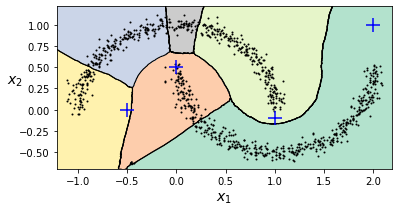

In [45]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

**AN IMPORTANT REMARK**

We notice that the two new instances that are very far away from either cluster were **still assigned to a cluster**, even though they may be considered anomalous.

In order to incorporate the classification of anomalies, we can do this by prescribing a **maximum distance** threshold condition for an instance to be an anomaly. We show how to do this below:

In [46]:
# The '.kneighbors' method outputs the distances and the indices of the k nearest neighbors
# (given a set of input instances)

y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)

In [47]:
y_pred = dbscan.labels_[core_indices][y_pred_idx]
y_pred[y_dist > 0.2] = -1 # Specifying condition for anomalies
y_pred.ravel()

array([-1,  1,  3, -1], dtype=int64)

## Gaussian Mixtures

To illustrate the use of GMM, we will first create artifical data, and then attempt to fit a GMM model to it.

In [48]:
# Making blob data (three blobs)
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)

# NOT SURE WHAT THIS IS DOING ?????
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2 = X2 + [6, -8]

# Getting final data set
X = np.r_[X1, X2]
y = np.r_[y1, y2]

We now create a GMM model to fit this data:

In [49]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components= 3, n_init = 10) # NOTE: We have to specify the number of clusters!!!

In [50]:
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

We have now essentially found the Gaussians the describe our data set. We can extract the parameters of each cluster, such as weights, means, and covariance matrices:

In [51]:
# Get the weights for the GMM (three of them)

gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [52]:
# Get the means for the Gaussians (three of them)

gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [53]:
# Get the covariance matrices for each cluster (three of them)

gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

**Assigning Instances and Making Predictions**

**NOTE: In SKL's implementation, the EM algorithm falls to the same trap as the k-means algorithm, where it may not converge to the most optimal solution. Hence, we must run the algorithm multiple times, the number set by the 'n_init' hyperparameter. By default, this is set to only 1!!!.**

We can actually see how many iterations it took for the EM algorithm to converge:

In [54]:
gm.converged_

True

In [55]:
gm.n_iter_

4

Now, we can assign the instances to each cluster, using either hard or soft clustering:

In [56]:
# Hard clustering
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

In [57]:
# Soft clustering
gm.predict_proba(X)

array([[9.77227791e-01, 2.27715290e-02, 6.79898914e-07],
       [9.83288385e-01, 1.60345103e-02, 6.77104389e-04],
       [7.51824662e-05, 1.90251273e-06, 9.99922915e-01],
       ...,
       [4.35053542e-07, 9.99999565e-01, 2.17938894e-26],
       [5.27837047e-16, 1.00000000e+00, 1.50679490e-41],
       [2.32355608e-15, 1.00000000e+00, 8.21915701e-41]])

Also, since the GMM has essentially found/created multiple Gaussian distributions, we can actually use these to sample from!

In [58]:
X_new, y_new = gm.sample(6)

In [59]:
X_new

array([[-0.75559006, -1.09672788],
       [ 0.39778285,  0.39677082],
       [ 0.33401581, -0.56742959],
       [ 1.99999666,  1.32734529],
       [ 3.44924765, -1.44594674],
       [-1.32338369,  1.42625247]])

In [60]:
y_new

array([0, 0, 0, 1, 1, 2])

We can also use the Gaussians to estimate the density of the model at the location of any instance using the 'score_samples()' method. This will compute the log of the PDF at that location.

Higher score -> higher density

In [61]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

**Visualize the Decision Boundaries**

Finally, we can visualize the decision boundaries created by the GMM model:

In [62]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

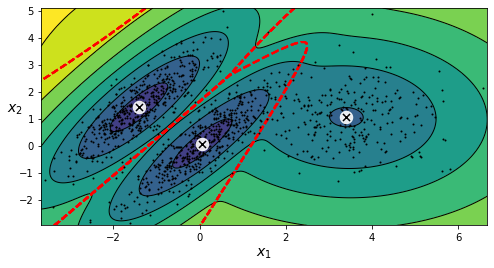

In [63]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)